In [73]:
import cv2
import numpy as np
import os
from sklearn.cluster  import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

### 基于SIFT,BOW的图像检索
#### 1、SIFT提取每幅图像的特征点
#### 2、聚类获取视觉单词中心（聚类中心），构造视觉单词词典
#### 3、将图像特征点映射到视觉单词上，得到图像特征
#### 4、计算待检索图像的最近邻图像

In [74]:
#  根据图像数据文件夹路径获取所有图片路径

training_path='images/'   #训练样本文件夹路径
training_names=os.listdir(training_path)
# 保留所有图片
pic_names=['bmp','jpg','png','tiff','gif','pcx','tga','exif','fpx','svg','psd','cdr','pcd','dxf','ufo','eps','ai','raw','WMF']
for name in training_names:
    file_format=name.split('.')[-1]
    if file_format not in pic_names:
        training_names.remove(name)
num_words=100  # 聚类中心数

img_paths=[]   # 所有图片路径
for name in training_names:
    img_path=os.path.join(training_path,name)
    img_paths.append(img_path)

In [75]:
img_paths

['images/1.png',
 'images/11.png',
 'images/12.png',
 'images/2.png',
 'images/3.png',
 'images/4.png',
 'images/5.png',
 'images/6.png',
 'images/7.png',
 'images/8.png',
 'images/9.png']

In [76]:
def getClusterCentures(img_paths,dataset_matrix,num_words):
    '''
    获取聚类中心
    
    img_paths:图像数据中所有图像路径
    dataset_matrix：图像数据的矩阵表示   注：img_paths dataset_matrix这两个参数只需要指定一个
    num_words:聚类中心数
    '''
    sift_det=cv2.xfeatures2d.SIFT_create()
    des_list=[]  # 特征描述
    des_matrix = np.zeros((1,128))
    #
    if img_paths != None:
        for path in img_paths:
            img=cv2.imread(path)
            gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            kp, des = sift_det.detectAndCompute(gray,None)
            #
            #if des.all():
            #if des != None:
            des_matrix=np.row_stack((des_matrix, des))
            des_list.append(des)
    elif dataset_matrix.all():
        for gray in range(dataset_matrix.shape[0]):
            kp, des = sift_det.detectAndCompute(gray,None)
            #
            #if des != None:
            #if des.all():    
            des_matrix = np.row_stack((des_matrix,des))
            des_list.append(des)
    else:
        raise ValueError('INPUT ERROR')
   
    des_matrix=des_matrix[1:, :]   # the des matrix of sift

    # 计算聚类中心  构造视觉单词词典
    kmeans=KMeans(n_clusters=num_words, random_state=33)
    kmeans.fit(des_matrix)
    centres = kmeans.cluster_centers_  # 视觉聚类中心
    print(kmeans.cluster_centers_.shape)
    return centres, des_list

In [77]:
centres, des_list = getClusterCentures(img_paths = img_paths, num_words = num_words, dataset_matrix = None)

(100, 128)


In [80]:
des_list[0].shape

(952, 128)

In [81]:
# 将特征描述转换为特征向量
def des2feature(des, num_words, centures):
    '''
    des:单幅图像的SIFT特征描述
    num_words:视觉单词数/聚类中心数
    centures:聚类中心坐标   num_words*128
    return: feature vector 1*num_words
    '''
    img_feature_vec = np.zeros((1,num_words),'float32')
    for i in range(des.shape[0]):
        feature_k_rows=np.ones((num_words,128),'float32')
        feature=des[i]
        feature_k_rows = feature_k_rows * feature
        feature_k_rows = np.sum((feature_k_rows-centures)**2,1)
        index = np.argmax(feature_k_rows)
        img_feature_vec[0][index] += 1
    return img_feature_vec

In [82]:
def get_all_features(des_list,num_words):
    # 获取所有图片的特征向量
    allvec=np.zeros((len(des_list),num_words),'float32')
    for i in range(len(des_list)):
        if len(des_list[i]) > 0:
            allvec[i] = des2feature(centures=centres,des=des_list[i],num_words=num_words)
    return allvec

#### 经过之前的操作，我们已经成功通过词袋表示法将SIFT提取的特征表示出来
#### 接下来计算待检索图像最近邻图像

In [83]:
def getNearestImg(feature, dataset, num_close):
    '''
    找出目标图像最像的几个
    feature:目标图像特征
    dataset:图像数据库
    num_close:最近个数
    return:最相似的几个图像
    '''
    features=np.ones((dataset.shape[0],len(feature)),'float32')
    features = features * feature
    dist = np.sum((features - dataset) ** 2, 1)
    dist_index = np.argsort(dist)
    return dist_index[:num_close]

In [84]:
def showImg(target_img_path, index, dataset_paths):
    '''
    target_img:要搜索的图像
    dataset_paths：图像数据库所有图片的路径
    显示最相似的图片集合
    '''
    # get img path
    paths=[]
    for i in index:
        paths.append(dataset_paths[i])
        
    plt.figure(figsize=(10,20))    #  figsize 用来设置图片大小
    plt.subplot(432),plt.imshow(plt.imread(target_img_path)),plt.title('target_image')
    
    for i in range(len(index)):
        plt.subplot(4, 3, i+4),plt.imshow(plt.imread(paths[i]))
    plt.show()

In [85]:
# 暴力搜索
def retrieval_img(img_path, img_dataset, centures, img_paths):
    '''
    检索图像，找出最像的几个
    img:待检索的图像
    img_dataset:图像数据库 matrix
    num_close:显示最近邻的图像数目
    centures:聚类中心
    img_paths:图像数据库所有图像路径
    '''
    num_close = 9
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sift_det = cv2.xfeatures2d.SIFT_create()
    kp, des = sift_det.detectAndCompute(img,None)
    feature = des2feature(des=des, centures=centures, num_words=num_words)
    sorted_index = getNearestImg(feature, img_dataset, num_close)
    
    showImg(img_path,sorted_index,img_paths)

In [86]:
# test
img_features = get_all_features(des_list=des_list, num_words=num_words)

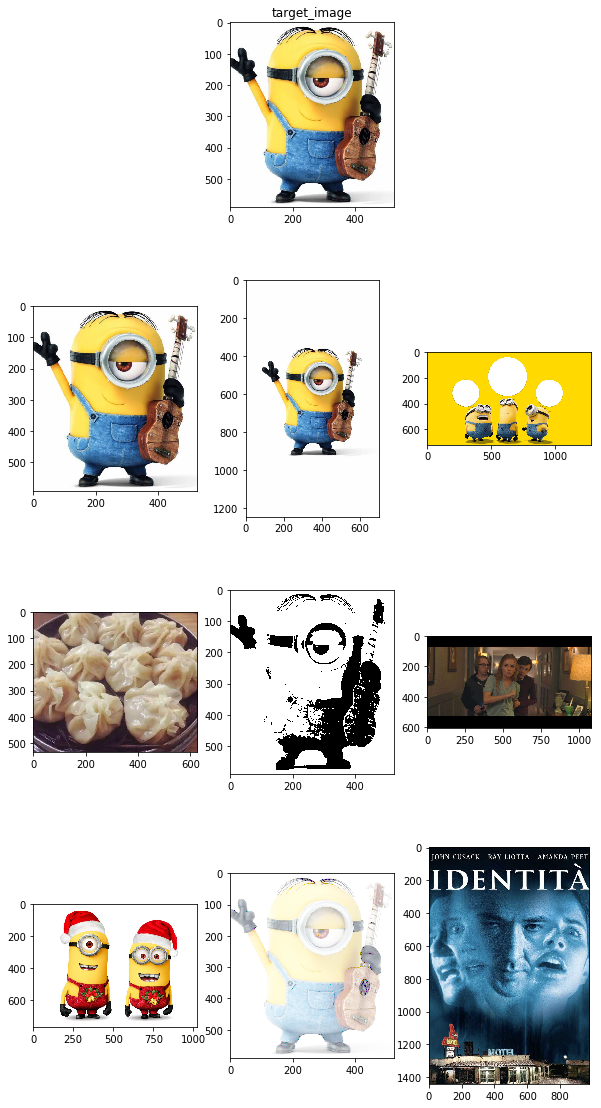

In [87]:
path = 'images/1.png'

retrieval_img(path, img_features, centres, img_paths)


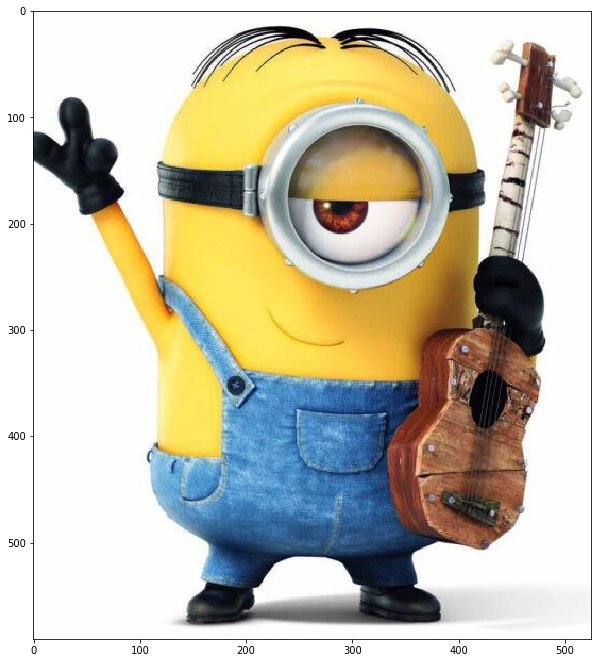

In [51]:
pic=plt.imread(path)
plt.figure(figsize=(10,20))
plt.imshow(pic)
plt.show()